# 6 - Additional Training Rounds<p>

In [1]:
from datasets import DatasetDict
ds_7 = DatasetDict.load_from_disk('pickles/7_labels_folder')
ds_20 = DatasetDict.load_from_disk('pickles/20_labels_folder')
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

In [2]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model_7 = DistilBertForSequenceClassification.from_pretrained(model_name,num_labels=7)
model_20 = DistilBertForSequenceClassification.from_pretrained(model_name,num_labels=20)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def tokenize_7(batch):
    return tokenizer(batch['no_stopword'], return_tensors='pt', truncation=True, padding=True)

In [4]:
def tokenize_20(batch):
    return tokenizer(batch['processed'], return_tensors='pt', truncation=True, padding=True)

In [5]:
tokens_train_7 = ds_7['train'].map(tokenize_7, batched=True)
tokens_test_7 = ds_7['test'].map(tokenize_7, batched=True)

Map:   0%|          | 0/7532 [00:00<?, ? examples/s]

In [6]:
tokens_train_20 = ds_20['train'].map(tokenize_20, batched=True)
tokens_test_20 = ds_20['test'].map(tokenize_20, batched=True)

In [7]:
import evaluate
import numpy as np
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
from transformers import TrainingArguments, Trainer

In [8]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get the predicted class labels
    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    # Compute F1 score
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    # Return both metrics
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}

In [9]:
training_args_7 = TrainingArguments(
    output_dir='multistep_7',
    report_to='none',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3)

trainer_7 = Trainer(
   model=model_7,
   args=training_args_7,
   train_dataset=tokens_train_7,
   eval_dataset=tokens_test_7,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics)

In [10]:
training_args_20 = TrainingArguments(
    output_dir='multistep_20',
    report_to='none',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4)

trainer_20 = Trainer(
   model=model_20,
   args=training_args_20,
   train_dataset=tokens_train_20,
   eval_dataset=tokens_test_20,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics)

In [11]:
trainer_7.train()

  0%|          | 0/2124 [00:00<?, ?it/s]

{'loss': 0.8526, 'grad_norm': 6.713099956512451, 'learning_rate': 1.529190207156309e-05, 'epoch': 0.71}
{'loss': 0.5135, 'grad_norm': 12.343777656555176, 'learning_rate': 1.0583804143126177e-05, 'epoch': 1.41}
{'loss': 0.4194, 'grad_norm': 12.529735565185547, 'learning_rate': 5.8757062146892665e-06, 'epoch': 2.12}
{'loss': 0.3201, 'grad_norm': 6.473957061767578, 'learning_rate': 1.167608286252354e-06, 'epoch': 2.82}
{'train_runtime': 857.5528, 'train_samples_per_second': 39.58, 'train_steps_per_second': 2.477, 'train_loss': 0.5134276751071046, 'epoch': 3.0}


TrainOutput(global_step=2124, training_loss=0.5134276751071046, metrics={'train_runtime': 857.5528, 'train_samples_per_second': 39.58, 'train_steps_per_second': 2.477, 'total_flos': 4496609362655232.0, 'train_loss': 0.5134276751071046, 'epoch': 3.0})

In [12]:
results_train_7 = trainer_7.evaluate(eval_dataset=tokens_train_7)
results_test_7 = trainer_7.evaluate(eval_dataset=tokens_test_7)

  0%|          | 0/708 [00:00<?, ?it/s]

  0%|          | 0/471 [00:00<?, ?it/s]

In [13]:
print("Training Evaluation Results:", results_train_7)
print("Test Evaluation Results:", results_test_7)

Training Evaluation Results: {'eval_loss': 0.2505316436290741, 'eval_accuracy': 0.9185080431324023, 'eval_f1': 0.9181996735015227, 'eval_runtime': 98.8073, 'eval_samples_per_second': 114.506, 'eval_steps_per_second': 7.165, 'epoch': 3.0}
Test Evaluation Results: {'eval_loss': 0.5992799401283264, 'eval_accuracy': 0.8088157195963888, 'eval_f1': 0.8076362184413346, 'eval_runtime': 65.7366, 'eval_samples_per_second': 114.579, 'eval_steps_per_second': 7.165, 'epoch': 3.0}


In [29]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
texts_7 = ds_7['test']['no_stopword']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_7.to(device)
batch_size = 8

In [25]:
def predict_in_batches_7(texts, batch_size):
    predictions = []
    # Iterate over texts in smaller batches
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        
        # Tokenize the batch
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        
        # Move inputs to the same device as the model
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Make predictions
        with torch.no_grad():  # no need to compute gradients
            outputs = model_7(**inputs)

        # Get predicted classes
        logits = outputs.logits
        predicted_classes = torch.argmax(logits, dim=-1).cpu().numpy()
        
        predictions.extend(predicted_classes)

    return predictions

In [27]:
data_7 = pd.DataFrame(ds_7['test'])
predicted_7 = predict_in_batches_7(texts_7, batch_size)
data_7['predicted'] = predicted_7

([], [])

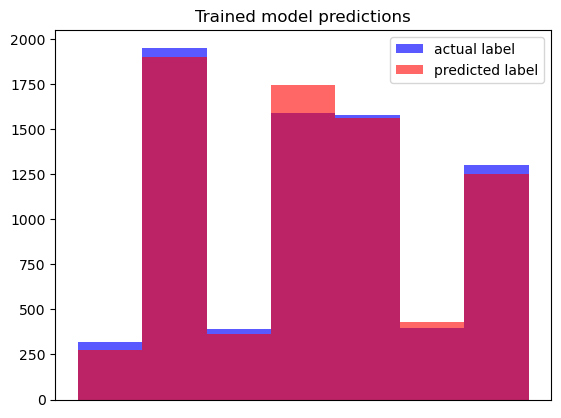

In [31]:
plt.hist(data_7['label'],bins=7,color='blue',alpha=0.65,label='actual label')
plt.hist(data_7['predicted'],bins=7,color='red',alpha=0.6,label='predicted label')
plt.legend()
plt.title('Trained model predictions')
plt.xticks([])

# plt.savefig('charts/preds_multistep_7.png',bbox_inches='tight')

**Evals**:<br>
Training:<ul>
accuracy: 0.919<br>
f1: 0.918</ul>

Test:<ul>
accuracy: 0.809<br>
f1: 0.808</ul>

Random Chance:<ul>
accuracy/f1: 0.14

In [32]:
evals_7 = {'training':[0.919,0.918],'test':[0.809,0.808],'random chance':[0.14,0.14]}
metrics_7 = pd.DataFrame.from_dict(evals_7,orient='index',columns=['accuracy','f1'])
metrics_7

,accuracy,f1
training,0.919,0.918
test,0.809,0.808
random chance,0.140,0.140


**Loss values**:<ul>
trainer 1: 0.8526<br>
trainer 2: 0.5135<br>
trainer 3: 0.4194<br>
trainer 4: 0.3201<br>
eval_train: 0.2505<br>
eval_test: 0.5993<br>
chance: 1.95<br>


In [33]:
data_7 = {'trainer1':[0.8526],'trainer2':[0.5135],'trainer3':[0.4194],'trainer4':[0.3201],'eval_train':[0.2505],'eval_test':[0.5993],'chance':[1.95]}
losses_7 = pd.DataFrame.from_dict(data_7,orient='index',columns=['loss'])
losses_7

,loss
trainer1,0.8526
trainer2,0.5135
trainer3,0.4194
trainer4,0.3201
eval_train,0.2505
eval_test,0.5993
chance,1.9500


In [14]:
# trainer_20.train()

# results_train_20 = trainer_20.evaluate(eval_dataset=tokens_train_20)
# results_test_20 = trainer_20.evaluate(eval_dataset=tokens_test_20)

# print("Training Evaluation Results:", results_train_20)
# print("Test Evaluation Results:", results_test_20)

In [ ]:
# texts_20 = ds_20['test']['processed']

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_20.to(device)
# batch_size = 8

In [ ]:
# def predict_in_batches_20(texts, batch_size):
#     predictions = []
#     # Iterate over texts in smaller batches
#     for i in range(0, len(texts), batch_size):
#         batch = texts[i:i+batch_size]
        
#         # Tokenize the batch
#         inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        
#         # Move inputs to the same device as the model
#         inputs = {key: value.to(device) for key, value in inputs.items()}

#         # Make predictions
#         with torch.no_grad():  # no need to compute gradients
#             outputs = model_20(**inputs)

#         # Get predicted classes
#         logits = outputs.logits
#         predicted_classes = torch.argmax(logits, dim=-1).cpu().numpy()
        
#         predictions.extend(predicted_classes)

#     return predictions

In [ ]:
# data_20 = pd.DataFrame(ds_20['test'])
# predicted_20 = predict_in_batches_20(texts_20, batch_size)
# data_20['predicted'] = predicted_20